In [1]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.feature_selection import SelectKBest,f_classif,chi2,f_regression

In [2]:
class DataPreprocess:
    def __init__(self, filename):
        self.filename = filename
        
    def read_in_data(self):
        return pd.read_csv(self.filename)

    def select_feature_manually(self):
        self.df = self.read_in_data()
        self.df_feature = self.df[["AIRLINE_ID", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID","LATITUDE", "LONGITUDE", "MONTH","DAY_OF_MONTH", "PLANE_AGE", "AWND", "PRCP", "SNOW", "TMAX", "TAVG",
             "CRS_DEP_TIME", "CRS_ARR_TIME", "DISTANCE"]]

    def convert_time(self, time):
        hour = np.floor(time/100)
        minutes = hour*60 + time - hour*100
        return minutes

    def make_dataset(self):
        airline_oh = pd.get_dummies(self.df_feature['AIRLINE_ID'])
        name = 'AIRLINE_ID'
        airline_oh_columns = []
        for i in range(airline_oh.shape[1]):
            airline_oh_columns.append(name+" "+str(i))
        
        airline = pd.DataFrame(airline_oh.to_numpy(),columns=airline_oh_columns)
        self.df_feature = self.df_feature.join(airline)
            
        arr_airport_oh = pd.get_dummies(self.df_feature['DEST_AIRPORT_ID'])
        name = 'DEST_AIRPORT_ID'
        arr_airport_oh_columns = []
        for i in range(arr_airport_oh.shape[1]):
            arr_airport_oh_columns.append(name+" "+str(i))
            
        arr_airport = pd.DataFrame(arr_airport_oh.to_numpy(),columns=arr_airport_oh_columns)
        self.df_feature = self.df_feature.join(arr_airport)
            
        dep_airport_oh = pd.get_dummies(self.df_feature['ORIGIN_AIRPORT_ID'])
        name = 'ORIGIN_AIRPORT_ID'
        dep_airport_oh_columns = []
        for i in range(dep_airport_oh.shape[1]):
            dep_airport_oh_columns.append(name+" "+str(i))
            
        dep_airport = pd.DataFrame(dep_airport_oh.to_numpy(),columns=dep_airport_oh_columns)
        self.df_feature = self.df_feature.join(dep_airport)

#         airline_oh = airline_oh_df.to_numpy()
#         arr_airport_oh = arr_airport_oh_df.to_numpy()
#         dep_airport_oh = dep_airport_oh_df.to_numpy()

        self.df_feature = self.df_feature.drop(['AIRLINE_ID', 'DEST_AIRPORT_ID', 'ORIGIN_AIRPORT_ID'], axis=1)

        self.df_feature = self.df_feature.fillna(0)

        arr_time = self.df_feature["CRS_ARR_TIME"].to_numpy().reshape(-1, 1)
        dep_time = self.df_feature["CRS_DEP_TIME"].to_numpy().reshape(-1, 1)
        arr_time_min = self.convert_time(arr_time)
        dep_time_min = self.convert_time(dep_time)
        time_min_df = pd.DataFrame(np.hstack([arr_time_min, dep_time_min]), columns=['CRS_ARR_TIME_MIN', 'CRS_DEP_TIME_MIN'])

        self.df_feature = self.df_feature.drop(["CRS_ARR_TIME", "CRS_DEP_TIME"], axis=1)
        self.df_feature = self.df_feature.join(time_min_df)

        features_without_id = self.df_feature.to_numpy()
        self.features = features_without_id # array
        self.df_truth = self.df[["CANCELLED", "DEP_DELAY_NEW", "ARR_DELAY_NEW"]]
    
    
    def generate(self):

        self.select_feature_manually()
        self.make_dataset()
    

        y = np.zeros((self.df_truth.shape[0],2))

        for i in range(6):
            if i==0:
                y[self.df_truth["DEP_DELAY_NEW"]==0, 0] = 0
                y[self.df_truth["ARR_DELAY_NEW"]==0, 1] = 0
            elif i==5:
                ub = (i-1)*15
                y[self.df_truth["DEP_DELAY_NEW"]>ub, 0] = ub
                y[self.df_truth["ARR_DELAY_NEW"]>ub, 1] = ub
            else: 
                lb = (i-1)*15
                ub = i*15
                y[np.logical_and(self.df_truth["DEP_DELAY_NEW"]>lb, self.df_truth["DEP_DELAY_NEW"]<=ub), 0] = lb
                y[np.logical_and(self.df_truth["ARR_DELAY_NEW"]>lb, self.df_truth["ARR_DELAY_NEW"]<=ub), 1] = lb       

        y = pd.DataFrame(y, columns=['dep','arr'])        
        
        return self.df_feature, self.features, self.df_truth, y

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
filename = "./Data/train_2019.csv"
data = DataPreprocess(filename)
X, _, y_truth, y = data.generate()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

## Adaboost
https://www.datacamp.com/community/tutorials/adaboost-classifier-python <br>
https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html#sphx-glr-auto-examples-ensemble-plot-adaboost-hastie-10-2-py

In [6]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

### Base learner: Decision Tree

In [7]:
from sklearn.metrics import confusion_matrix

#### 1. Departure

In [8]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train["dep"])

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test["dep"], y_pred))

Accuracy: 0.796260290966505


Confusion matrix, without normalization
[[528993      0      0      0    314]
 [ 44930      0      0      0    116]
 [ 24672      0      0      0     69]
 [ 15964      0      0      0     71]
 [ 49356      0      0      0    540]]


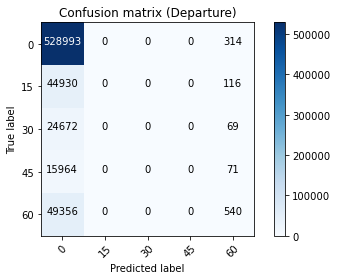

In [9]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test["dep"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Departure)')

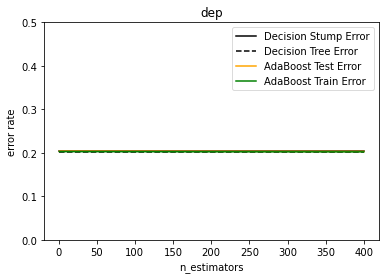

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

name = "dep"

n_estimators = 400
learning_rate = 0.5

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train[name])
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test[name])

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train[name])
dt_err = 1.0 - dt.score(X_test, y_test[name])


ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)
ada_real.fit(X_train, y_train[name])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, "k-", label="Decision Stump Error")
ax.plot([1, n_estimators], [dt_err] * 2, "k--", label="Decision Tree Error")

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test[name])

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train[name])


ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="AdaBoost Test Error",
    color="orange",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="AdaBoost Train Error",
    color="green",
)

ax.set_ylim((0.0, 0.5))
ax.set_xlabel("n_estimators")
ax.set_ylabel("error rate")

leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.title(name)
plt.show()

#### 2. Arrival

In [10]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train["arr"])

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test["arr"], y_pred))

Accuracy: 0.7916168565091538


Confusion matrix, without normalization
[[525358      0      0      0    676]
 [ 47053      0      0      0    264]
 [ 25079      0      0      0    203]
 [ 16067      0      0      0    175]
 [ 49063      0      0      0   1087]]


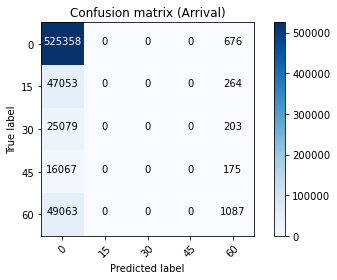

In [11]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test["arr"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Arrival)')

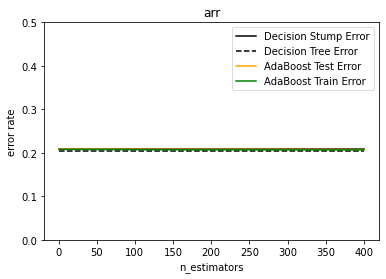

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

name = "arr"

n_estimators = 400
learning_rate = 0.5

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train[name])
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test[name])

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train[name])
dt_err = 1.0 - dt.score(X_test, y_test[name])


ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)
ada_real.fit(X_train, y_train[name])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, "k-", label="Decision Stump Error")
ax.plot([1, n_estimators], [dt_err] * 2, "k--", label="Decision Tree Error")

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test[name])

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train[name])


ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="AdaBoost Test Error",
    color="orange",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="AdaBoost Train Error",
    color="green",
)

ax.set_ylim((0.0, 0.5))
ax.set_xlabel("n_estimators")
ax.set_ylabel("error rate")

leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.title(name)
plt.show()

## KNN
https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/

#### 1. Departure

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

k_range = list(range(1, 16))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search = grid.fit(X_train, y_train["dep"])
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

y_pred = grid.predict(X_test)


Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 145.6min finished


Accuracy for our training dataset with tuning is : 79.55%


In [13]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test["dep"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 79.46%


In [14]:
from sklearn.metrics import confusion_matrix

# departure
confusion_matrix(y_test["dep"], y_pred, labels=[0, 15, 30, 45, 60])

array([[526019,    582,    145,     63,   2498],
       [ 44137,    253,     40,     23,    593],
       [ 24072,    111,     59,     14,    485],
       [ 15530,     73,     35,     16,    381],
       [ 47502,    189,     75,     32,   2098]])

Confusion matrix, without normalization
[[526019    582    145     63   2498]
 [ 44137    253     40     23    593]
 [ 24072    111     59     14    485]
 [ 15530     73     35     16    381]
 [ 47502    189     75     32   2098]]


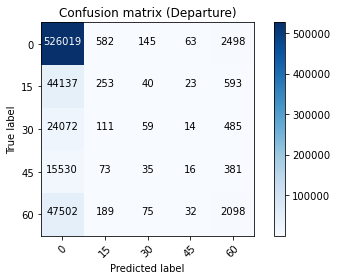

In [15]:
cnf_matrix = confusion_matrix(y_test["dep"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Departure)')

#### 2. Arrival

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

k_range = list(range(1, 16))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search = grid.fit(X_train, y_train["arr"])
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

y_pred = grid.predict(X_test)
test_accuracy = accuracy_score(y_test["arr"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 121.8min finished


Accuracy for our training dataset with tuning is : 79.03%
Accuracy for our testing dataset with tuning is : 78.96%


In [17]:
from sklearn.metrics import confusion_matrix

# departure
confusion_matrix(y_test["arr"], y_pred, labels=[0, 15, 30, 45, 60])

array([[522754,    544,    136,     68,   2532],
       [ 46389,    236,     43,     11,    638],
       [ 24632,    100,     47,     15,    488],
       [ 15738,     81,     25,     14,    384],
       [ 47785,    199,     55,     28,   2083]])

Confusion matrix, without normalization
[[522754    544    136     68   2532]
 [ 46389    236     43     11    638]
 [ 24632    100     47     15    488]
 [ 15738     81     25     14    384]
 [ 47785    199     55     28   2083]]


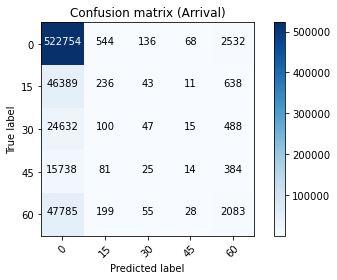

In [18]:
cnf_matrix = confusion_matrix(y_test["arr"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Arrival)')

## Random Forest
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 <br>
https://machinelearningmastery.com/random-forest-ensemble-in-python/

#### 1. Classification - dep

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_dep = RandomForestClassifier(n_estimators=20)
rf_dep.fit(X_train, y_train["dep"])
# make a single prediction
y_pred = rf_dep.predict(X_test)
# Calculate the absolute errors
error_rate = len(y_pred[y_pred!=y_test["dep"]])/len(y_pred)
print("Error Rate:", error_rate)

train_accuracy = accuracy_score(y_train["dep"],rf_dep.predict(X_train))*100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )

test_accuracy = accuracy_score(y_test["dep"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Error Rate: 0.17706402014961845
Accuracy for our training dataset with tuning is : 99.28%
Accuracy for our testing dataset with tuning is : 82.29%


Confusion matrix, without normalization
[[522694   2156    734    372   3351]
 [ 37484   5984    232    107   1239]
 [ 19943    369   3277    111   1041]
 [ 12560    254    139   2116    966]
 [ 35433    648    362    251  13202]]


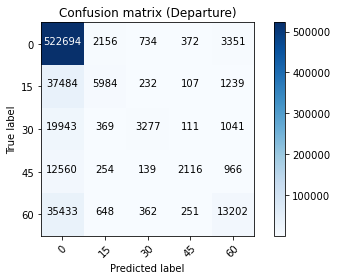

In [20]:
cnf_matrix = confusion_matrix(y_test["dep"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Departure)')

#### 2. Classification - arr

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_dep = RandomForestClassifier(n_estimators=20)
rf_dep.fit(X_train, y_train["arr"])
# make a single prediction
y_pred = rf_dep.predict(X_test)
# Calculate the absolute errors
error_rate = len(y_pred[y_pred!=y_test["arr"]])/len(y_pred)
print("Error Rate:", error_rate)

train_accuracy = accuracy_score(y_train["arr"],rf_dep.predict(X_train))*100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )

test_accuracy = accuracy_score(y_test["arr"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Error Rate: 0.1786429081613473
Accuracy for our training dataset with tuning is : 99.30%
Accuracy for our testing dataset with tuning is : 82.14%


Confusion matrix, without normalization
[[519267   2212    783    379   3393]
 [ 39254   6172    328    183   1380]
 [ 19834    510   3427    150   1361]
 [ 12273    329    189   2183   1268]
 [ 33391    740    507    338  15174]]


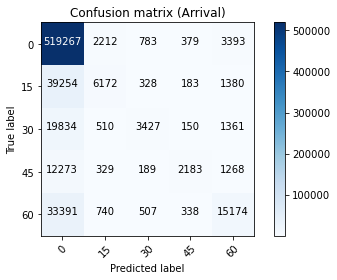

In [22]:
cnf_matrix = confusion_matrix(y_test["arr"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Arrival)')

## Random Forest (# of estimators: 50)
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 <br>
https://machinelearningmastery.com/random-forest-ensemble-in-python/

#### 1. Classification - dep

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_dep = RandomForestClassifier(n_estimators=50)
rf_dep.fit(X_train, y_train["dep"])
# make a single prediction
y_pred = rf_dep.predict(X_test)
# Calculate the absolute errors
error_rate = len(y_pred[y_pred!=y_test["dep"]])/len(y_pred)
print("Error Rate:", error_rate)

train_accuracy = accuracy_score(y_train["dep"],rf_dep.predict(X_train))*100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )

test_accuracy = accuracy_score(y_test["dep"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Error Rate: 0.17353934062629225
Accuracy for our training dataset with tuning is : 99.92%
Accuracy for our testing dataset with tuning is : 82.65%


Confusion matrix, without normalization
[[524464   1347    477    239   2780]
 [ 37632   6057    168     71   1118]
 [ 19960    299   3373     78   1031]
 [ 12600    179    124   2180    952]
 [ 35412    486    248    207  13543]]


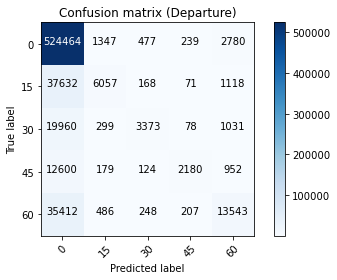

In [26]:
cnf_matrix = confusion_matrix(y_test["dep"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Departure)')

#### 2. Classification - arr

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_dep = RandomForestClassifier(n_estimators=50)
rf_dep.fit(X_train, y_train["arr"])
# make a single prediction
y_pred = rf_dep.predict(X_test)
# Calculate the absolute errors
error_rate = len(y_pred[y_pred!=y_test["arr"]])/len(y_pred)
print("Error Rate:", error_rate)

train_accuracy = accuracy_score(y_train["arr"],rf_dep.predict(X_train))*100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )

test_accuracy = accuracy_score(y_test["arr"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Error Rate: 0.1751377767753092
Accuracy for our training dataset with tuning is : 99.93%
Accuracy for our testing dataset with tuning is : 82.49%


Confusion matrix, without normalization
[[521066   1375    513    236   2844]
 [ 39374   6267    254    127   1295]
 [ 19916    403   3501    121   1341]
 [ 12326    227    168   2229   1292]
 [ 33391    613    393    262  15491]]


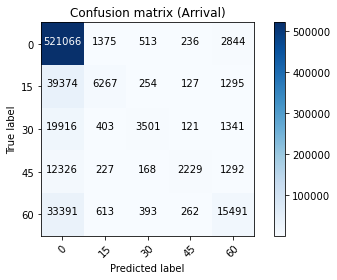

In [28]:
cnf_matrix = confusion_matrix(y_test["arr"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Arrival)')

## XGBoost
https://www.datacamp.com/community/tutorials/xgboost-in-python

#### 1. Classification - dep

In [29]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [30]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train["dep"])

In [31]:
xg_clf = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)
xg_clf.fit(X_train,y_train["dep"])
y_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test["dep"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

/Users/tracyliu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy for our testing dataset with tuning is : 79.63%


Confusion matrix, without normalization
[[529258      0      0      0     49]
 [ 45031      0      0      0     15]
 [ 24727      0      0      0     14]
 [ 16011      0      0      0     24]
 [ 49608      0      0      0    288]]


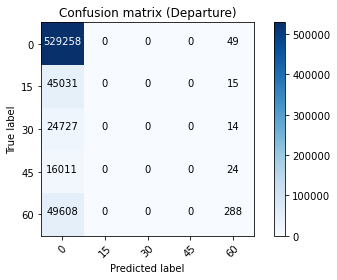

In [32]:
cnf_matrix = confusion_matrix(y_test["dep"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Departure)')

#### 2. Classification - arr

In [33]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train["arr"])

In [34]:
xg_clf = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)
xg_clf.fit(X_train,y_train["arr"])
y_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test["arr"],y_pred)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

[21:31:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy for our testing dataset with tuning is : 79.21%


Confusion matrix, without normalization
[[525892      0      0      0    142]
 [ 47227      0      0      0     90]
 [ 25191      0      0      0     91]
 [ 16159      0      0      0     83]
 [ 49256      0      0      0    894]]


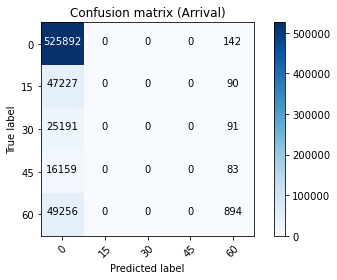

In [35]:
cnf_matrix = confusion_matrix(y_test["arr"], y_pred, labels=[0, 15, 30, 45, 60])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 15, 30, 45, 60],
                      title='Confusion matrix (Arrival)')